<a href="https://colab.research.google.com/github/krsnewwave/huggingface-explorations/blob/main/Explore_DrugDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time to slice and dice

Install the Transformers and Datasets libraries to run this notebook.

In [ ]:
!pip install datasets transformers[sentencepiece]

     |████████████████████████████████| 311 kB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 42.9 MB/s 
     |████████████████████████████████| 133 kB 53.2 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 243 kB 40.8 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 42.1 MB/s 
     |████████████████████████████████| 144 kB 49.0 MB/s 
     |████████████████████████████████| 895 kB 52.5 MB/s 
     |████████████████████████████████| 6.8 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 51.8 MB/s 
     |████████████████████████████████| 1.2 MB 40.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2022-02-07 06:58:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  29.2MB/s    in 1.4s    

2022-02-07 06:58:40 (29.2 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

Using custom data configuration default-3761173c276c0a9a


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-3761173c276c0a9a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
len(drug_dataset["train"]), len(drug_dataset["test"])

(161297, 53766)

## Sampling - 1000 only.
Uncomment if necessary

In [ ]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))

## Dataset Preprocessing
- Cleaning columns
- Fixing Labels

In [ ]:
for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

In [ ]:
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)

In [ ]:
# useful lambdas
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}

def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

# filter null condition for classification
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

# lower case
drug_dataset = drug_dataset.map(lowercase_condition)

# extract review length
drug_dataset = drug_dataset.map(compute_review_length)

# filter reviews with length >=30
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)

# filter 

  0%|          | 0/162 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
# unescape html
import html

text = "I&#039;m a transformer called BERT"

drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)

  0%|          | 0/139 [00:00<?, ?ba/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

## Tokenization

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_split(examples, tokenizer, max_length = 128, truncation=True, return_overflow=True, keep_old=False):
    """
    This method truncates the input to max_length, then the overflowing tokens become new samples
    """
    result = tokenizer(
        examples["review"],
        truncation=truncation,
        max_length=max_length,
        return_overflowing_tokens=return_overflow,
    )

    if keep_old:
        # Extract mapping between new and old indices
        sample_map = result.pop("overflow_to_sample_mapping")
        for key, values in examples.items():
            result[key] = [values[i] for i in sample_map]
            
    return result

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
from functools import partial
# the following will remove old column names
# fun_tokenization = partial(tokenize_and_split, tokenizer=tokenizer)

# the following retains old column names
fun_tokenization = partial(tokenize_and_split, tokenizer=tokenizer, keep_old=True)

tokenized_dataset = drug_dataset.map(
    fun_tokenization, batched=True, remove_columns=drug_dataset["train"].column_names
)

  0%|          | 0/139 [00:00<?, ?ba/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'condition_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 206772
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'condition_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 68876
    })
})

## EDA
1. Distribution of labels
1. Number of tokens per label
1. Most common words/tokens


 

In [ ]:
df = tokenized_dataset["train"].to_pandas()

In [ ]:
df[:5]

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,condition_length,input_ids,token_type_ids,attention_mask
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141,4,"[101, 107, 1422, 1488, 1110, 9079, 1194, 1117,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141,4,"[101, 119, 1124, 1110, 1750, 6438, 113, 170, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134,13,"[101, 107, 146, 1215, 1106, 1321, 1330, 9619, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134,13,"[101, 1111, 1160, 2277, 1105, 1208, 1122, 112,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89,13,"[101, 107, 1188, 1110, 1139, 1148, 1159, 1606,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# category frequencies
vc_freq = df["condition"].value_counts().to_frame("count").reset_index()
vc_freq.rename(columns={"index": "condition"}, inplace=True)
vc_freq["count"].describe()

count      819.000000
mean       252.468864
std       1716.612611
min          1.000000
25%          3.000000
50%         11.000000
75%         65.000000
max      43445.000000
Name: count, dtype: float64

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# get only categories with at least 200 samples
vc_freq_tops = vc_freq[vc_freq["count"] >= 200]
list_top_cats = vc_freq_tops["condition"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


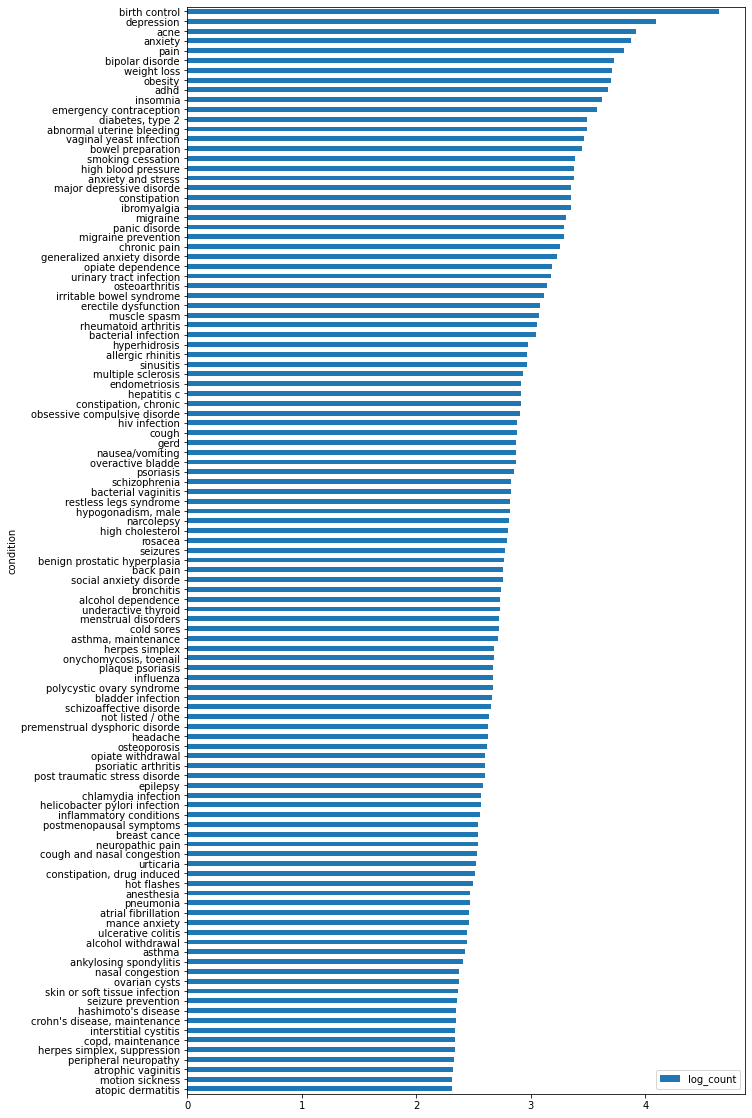

In [ ]:
_, ax = plt.subplots(figsize=(10, 20))
vc_freq_tops["log_count"] = np.log10(vc_freq_tops["count"])
vc_freq_tops[::-1].plot.barh(x="condition", y="log_count", ax=ax,)

In [ ]:
tokenizer.special_tokens_map_extended

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
vc_tokens = df["input_ids"].explode().value_counts().to_frame("count").reset_index()
vc_tokens.rename(columns={'index':'token'}, inplace=True)

In [ ]:
vc_tokens["decoded"] = vc_tokens["token"].apply(tokenizer.decode)
# incldue only 3 letter tokens
vc_tokens = vc_tokens[vc_tokens["decoded"].str.len() >= 3]

In [ ]:
tokenizer.special_tokens_map.values()

dict_values(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'])

In [ ]:
# remove specials
vc_tokens = vc_tokens[~vc_tokens["decoded"].isin(tokenizer.special_tokens_map.values())]
vc_tokens

,token,count,decoded
3,1105,412480,and
4,1103,355456,the
13,1111,187317,for
14,1108,169998,was
16,1138,163317,have
...,...,...,...
18889,19387,1,##gong
18891,23725,1,Survivor
18892,15444,1,Congressman
18893,5371,1,Transport


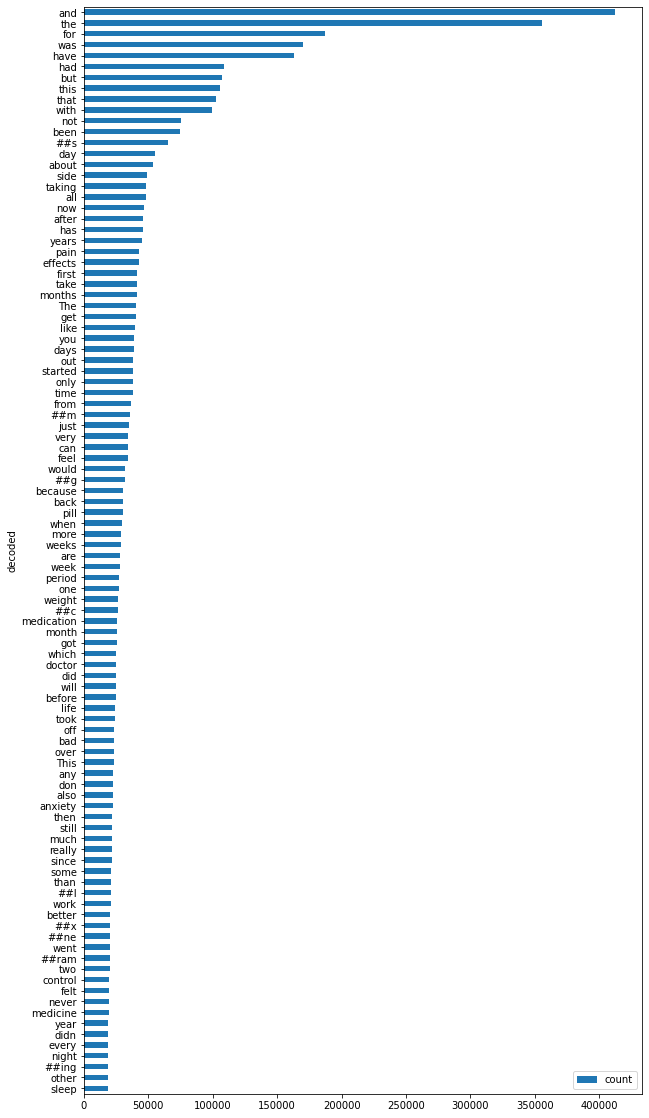

In [ ]:
_, ax = plt.subplots(figsize=(10, 20))
vc_tokens[:100][::-1].plot.barh(x="decoded", y="count", ax=ax)

## Validation Set

In [ ]:
drug_dataset.reset_format()

In [ ]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'condition_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'condition_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'condition_length'],
        num_rows: 46108
    })
})

# Classification

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b